# Wine Quality Prediction

# Import Libraries and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
import joblib
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Exploration

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
print(f"Dataset Shape: {data.shape}")
print(f"Features: {list(data.columns)}")
print(f"Target Distribution:\n{data['quality'].value_counts().sort_index()}")

Dataset Shape: (1599, 12)
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Target Distribution:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


# Data Quality Assessment

In [ ]:
missing_data = data.isnull().sum()
duplicate_rows = data.duplicated().sum()
data_types = data.dtypes
print(f"Missing Values:\n{missing_data}")
print(f"Duplicate Rows: {duplicate_rows}")
print(f"Data Types:\n{data_types}")
basic_stats = data.describe()
print(f"Basic Statistics:\n{basic_stats}")

Missing Values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Duplicate Rows: 240
Data Types:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object
Basic Statistics:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806  

# Target Variable Analysis

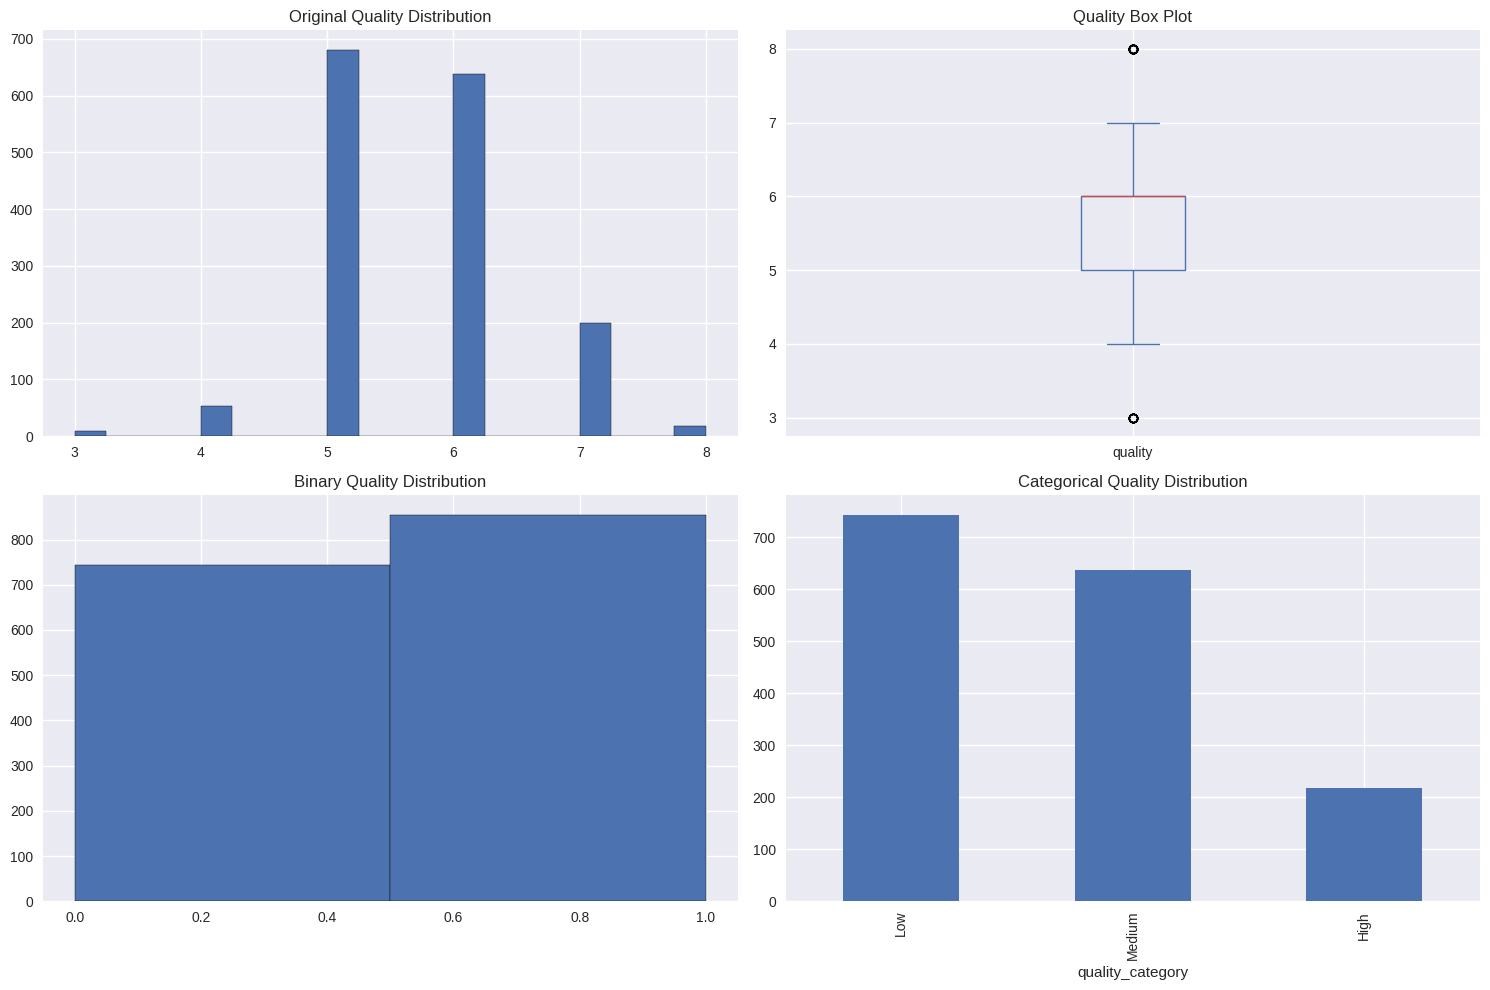

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
data['quality'].hist(bins=20, ax=axes[0,0], edgecolor='black')
axes[0,0].set_title('Original Quality Distribution')
data['quality'].plot(kind='box', ax=axes[0,1])
axes[0,1].set_title('Quality Box Plot')
data['quality_binary'] = (data['quality'] >= 6).astype(int)
data['quality_category'] = pd.cut(data['quality'], bins=[2, 5, 6, 8], labels=['Low', 'Medium', 'High'])
data['quality_binary'].hist(bins=2, ax=axes[1,0], edgecolor='black')
axes[1,0].set_title('Binary Quality Distribution')
data['quality_category'].value_counts().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Categorical Quality Distribution')
plt.tight_layout()
plt.show()

# Correlation Analysis and Feature Relationships


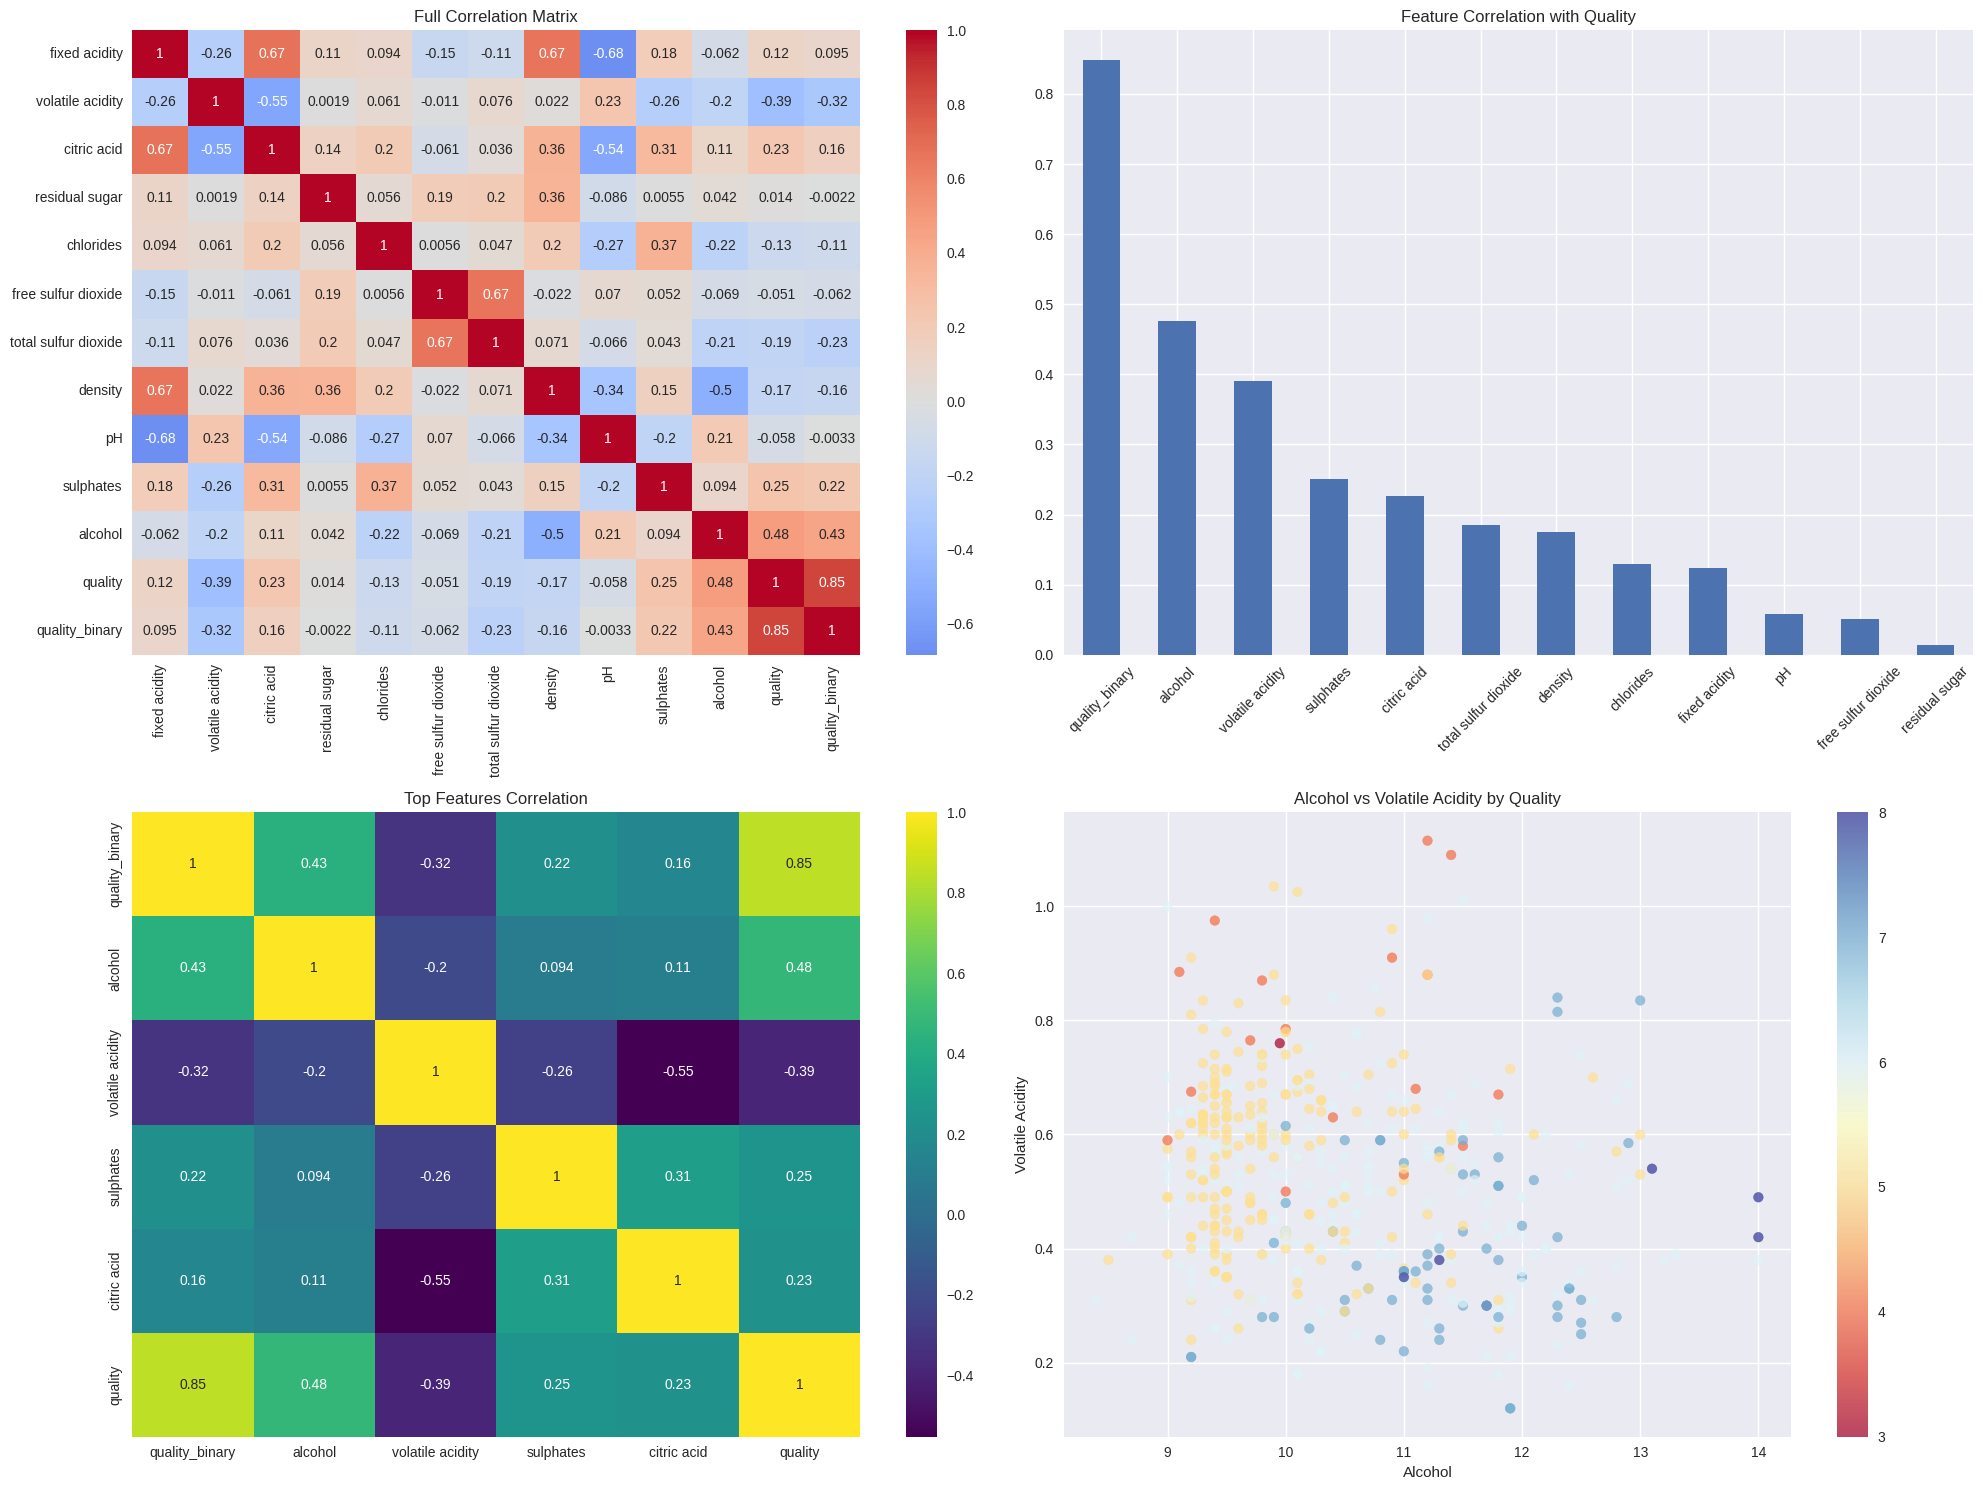

In [ ]:
correlation_matrix = data.select_dtypes(include=[np.number]).corr()
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,0])
axes[0,0].set_title('Full Correlation Matrix')
quality_corr = correlation_matrix['quality'].abs().sort_values(ascending=False)
quality_corr[1:].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Feature Correlation with Quality')
axes[0,1].tick_params(axis='x', rotation=45)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))
top_features = quality_corr[1:6].index
sns.heatmap(data[list(top_features) + ['quality']].corr(), annot=True, cmap='viridis', ax=axes[1,0])
axes[1,0].set_title('Top Features Correlation')
scatter_data = data[['alcohol', 'volatile acidity', 'quality']].sample(500)
scatter = axes[1,1].scatter(scatter_data['alcohol'], scatter_data['volatile acidity'],
                           c=scatter_data['quality'], cmap='RdYlBu', alpha=0.7)
axes[1,1].set_xlabel('Alcohol')
axes[1,1].set_ylabel('Volatile Acidity')
axes[1,1].set_title('Alcohol vs Volatile Acidity by Quality')
plt.colorbar(scatter, ax=axes[1,1])
plt.tight_layout()
plt.show()

# Distribution Analysis and Normality Tests

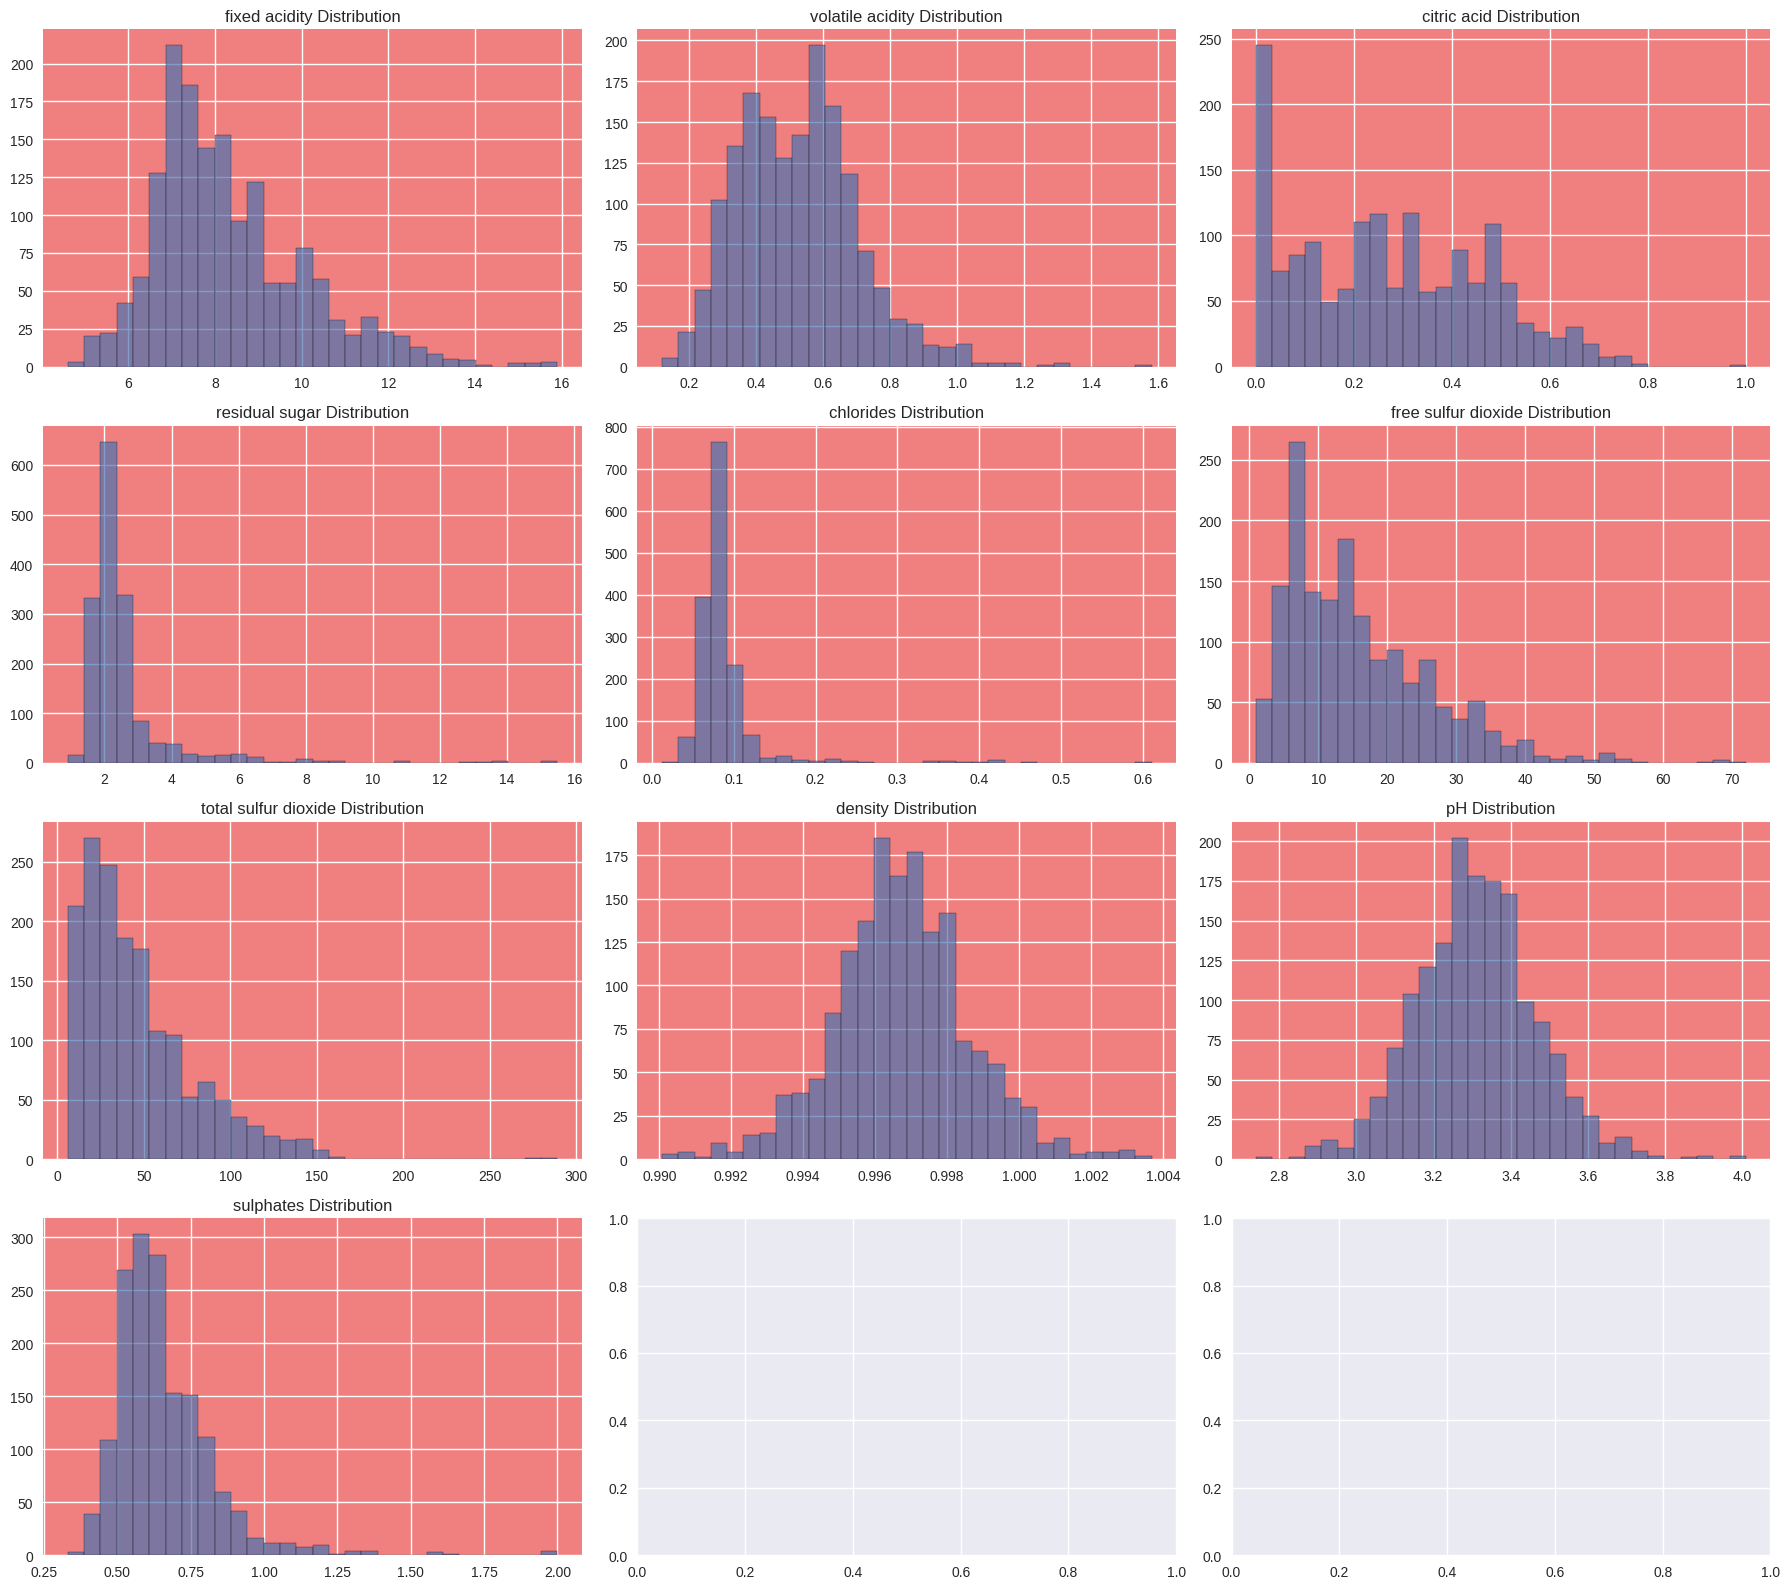

Normality Test Results:
fixed acidity: Non-normal (p=0.0000)
volatile acidity: Non-normal (p=0.0000)
citric acid: Non-normal (p=0.0000)
residual sugar: Non-normal (p=0.0000)
chlorides: Non-normal (p=0.0000)
free sulfur dioxide: Non-normal (p=0.0000)
total sulfur dioxide: Non-normal (p=0.0000)
density: Non-normal (p=0.0000)
pH: Non-normal (p=0.0000)
sulphates: Non-normal (p=0.0000)


In [ ]:
numeric_features = data.select_dtypes(include=[np.number]).columns[:-3]
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.ravel()
normality_results = {}
for i, feature in enumerate(numeric_features):
    data[feature].hist(bins=30, ax=axes[i], alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{feature} Distribution')
    stat, p_value = normaltest(data[feature])
    normality_results[feature] = {'statistic': stat, 'p_value': p_value, 'normal': p_value > 0.05}
    if not normality_results[feature]['normal']:
        axes[i].set_facecolor('lightcoral')
plt.tight_layout()
plt.show()
print("Normality Test Results:")
for feature, result in normality_results.items():
    status = "Normal" if result['normal'] else "Non-normal"
    print(f"{feature}: {status} (p={result['p_value']:.4f})")

# Advanced Statistical Tests and Quality Analysis


In [ ]:
quality_groups = data.groupby('quality')
anova_results = {}
kruskal_results = {}
for feature in numeric_features:
    groups = [group[feature].values for name, group in quality_groups]
    f_stat, f_p = stats.f_oneway(*groups)
    h_stat, h_p = stats.kruskal(*groups)
    anova_results[feature] = {'f_stat': f_stat, 'p_value': f_p, 'significant': f_p < 0.05}
    kruskal_results[feature] = {'h_stat': h_stat, 'p_value': h_p, 'significant': h_p < 0.05}
significant_features_anova = [f for f, r in anova_results.items() if r['significant']]
significant_features_kruskal = [f for f, r in kruskal_results.items() if r['significant']]
print(f"ANOVA Significant Features: {len(significant_features_anova)}")
print(f"Kruskal-Wallis Significant Features: {len(significant_features_kruskal)}")

ANOVA Significant Features: 9
Kruskal-Wallis Significant Features: 9


# Box Plot Analysis by Quality Categories


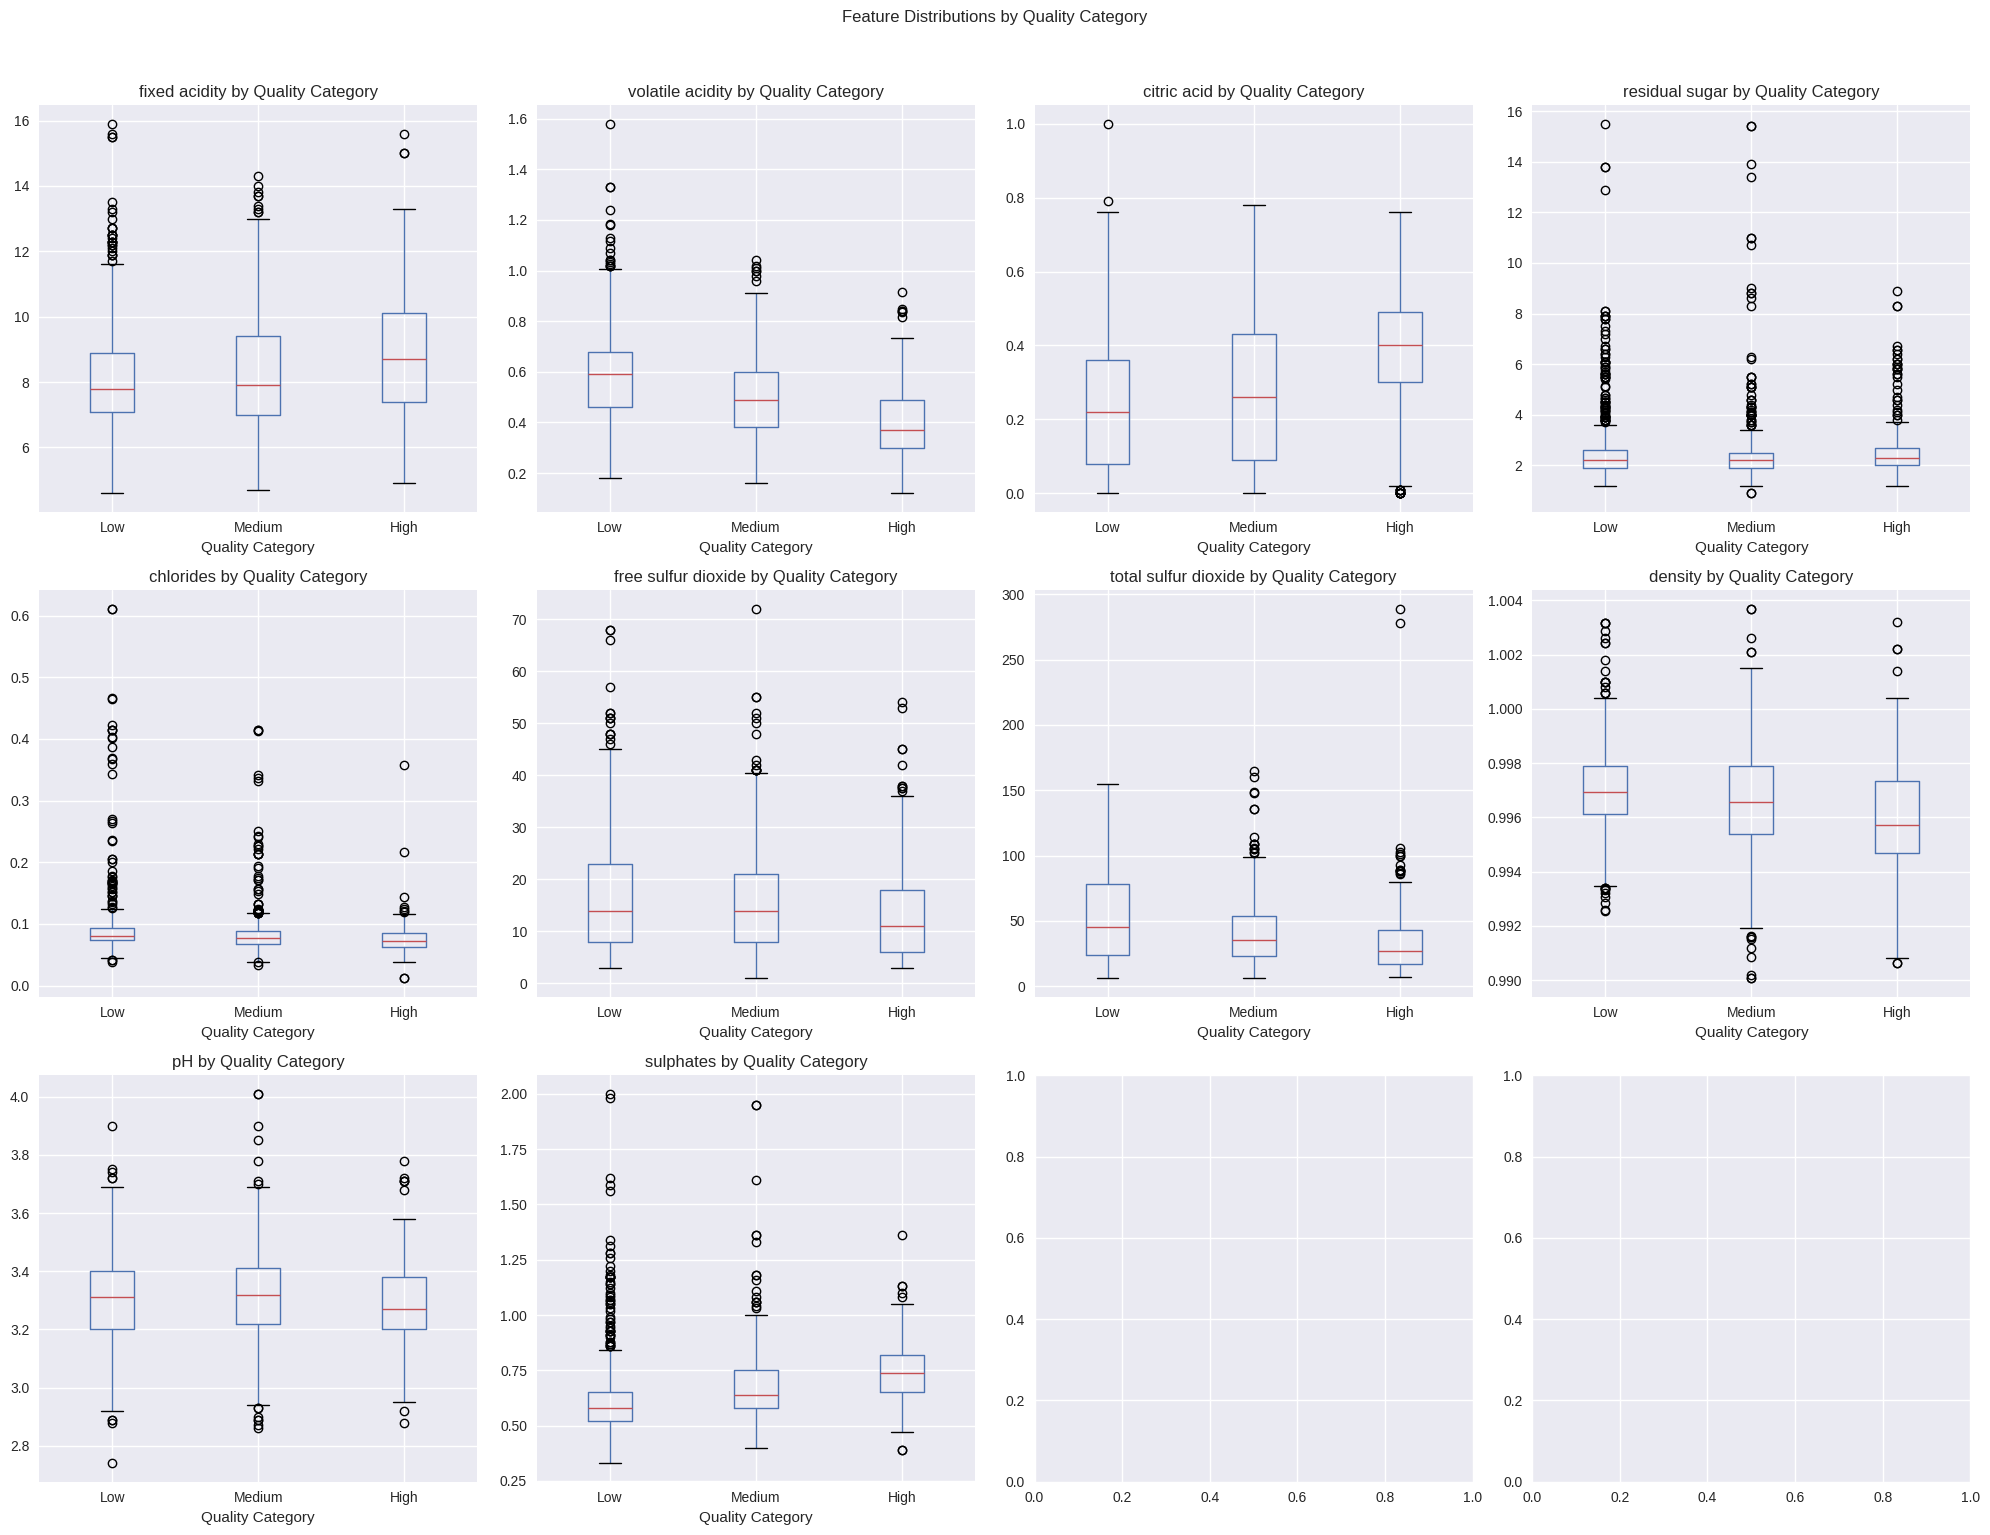

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()
for i, feature in enumerate(numeric_features):
    data.boxplot(column=feature, by='quality_category', ax=axes[i])
    axes[i].set_title(f'{feature} by Quality Category')
    axes[i].set_xlabel('Quality Category')
plt.suptitle('Feature Distributions by Quality Category', y=1.02)
plt.tight_layout()
plt.show()

# Feature Engineering - Polynomial and Interaction Features

In [9]:
feature_columns = data.select_dtypes(include=[np.number]).columns[:-3]
X_base = data[feature_columns].copy()
y = data['quality_binary'].copy()
poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly_features.fit_transform(X_base)
poly_feature_names = poly_features.get_feature_names_out(feature_columns)
X_engineered = pd.DataFrame(X_poly, columns=poly_feature_names)
data['alcohol_acidity_ratio'] = data['alcohol'] / (data['volatile acidity'] + 0.001)
data['acid_balance'] = data['fixed acidity'] - data['volatile acidity']
data['sulfur_ratio'] = data['free sulfur dioxide'] / (data['total sulfur dioxide'] + 0.001)
data['alcohol_quality_interaction'] = data['alcohol'] * data['quality']
data['density_alcohol_interaction'] = data['density'] * data['alcohol']
engineered_features = ['alcohol_acidity_ratio', 'acid_balance', 'sulfur_ratio',
                      'alcohol_quality_interaction', 'density_alcohol_interaction']
print(f"Original features: {len(feature_columns)}")
print(f"Polynomial features: {X_engineered.shape[1]}")
print(f"Custom engineered features: {len(engineered_features)}")

Original features: 10
Polynomial features: 65
Custom engineered features: 5


# Comprehensive Preprocessing Pipeline Setup


In [10]:
X_final = pd.concat([X_base, data[engineered_features]], axis=1)
y_final = data['quality_binary'].copy()
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2,
                                                    random_state=42, stratify=y_final)
preprocessing_methods = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'power': PowerTransformer(method='yeo-johnson'),
    'quantile': QuantileTransformer(n_quantiles=100, random_state=42)
}
preprocessed_data = {}
for name, scaler in preprocessing_methods.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    preprocessed_data[name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'scaler': scaler
    }
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution in training: {np.bincount(y_train)}")

Training set shape: (1279, 15)
Test set shape: (320, 15)
Class distribution in training: [595 684]


# Model Definitions and Hyperparameter Grids

In [11]:
models = {
    'logistic': LogisticRegression(random_state=42, max_iter=1000),
    'ridge': Ridge(random_state=42),
    'lasso': Lasso(random_state=42, max_iter=1000),
    'elastic_net': ElasticNet(random_state=42, max_iter=1000),
    'decision_tree': DecisionTreeClassifier(random_state=42),
    'random_forest': RandomForestClassifier(random_state=42),
    'gradient_boosting': GradientBoostingClassifier(random_state=42),
    'ada_boost': AdaBoostClassifier(random_state=42),
    'svc': SVC(random_state=42, probability=True),
    'knn': KNeighborsClassifier(),
    'mlp': MLPClassifier(random_state=42, max_iter=1000)
}
param_grids = {
    'logistic': {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
    'ridge': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'lasso': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'elastic_net': {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
    'decision_tree': {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'random_forest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5, 10]},
    'gradient_boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'ada_boost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]},
    'svc': {'C': [0.1, 1, 10, 100], 'kernel': ['rbf', 'poly'], 'gamma': ['scale', 'auto']},
    'knn': {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    'mlp': {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], 'alpha': [0.0001, 0.001, 0.01], 'learning_rate_init': [0.001, 0.01]}
}

# Model Training and Hyperparameter Optimization

In [12]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}
training_scores = {}
for preprocessing_name, prep_data in preprocessed_data.items():
    if preprocessing_name == 'standard':
        print(f"Training models with {preprocessing_name} preprocessing...")
        X_train_prep = prep_data['X_train']
        X_test_prep = prep_data['X_test']

        for model_name, model in models.items():
            print(f"Optimizing {model_name}...")
            param_grid = param_grids[model_name]

            random_search = RandomizedSearchCV(
                model, param_grid, n_iter=20, cv=cv_strategy,
                scoring='f1', random_state=42, n_jobs=-1
            )

            random_search.fit(X_train_prep, y_train)
            best_models[model_name] = random_search.best_estimator_

            cv_scores = cross_val_score(random_search.best_estimator_, X_train_prep, y_train,
                                      cv=cv_strategy, scoring='f1')
            training_scores[model_name] = {
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'best_params': random_search.best_params_,
                'best_score': random_search.best_score_
            }
print("Model optimization completed.")

Training models with standard preprocessing...
Optimizing logistic...
Optimizing ridge...
Optimizing lasso...
Optimizing elastic_net...
Optimizing decision_tree...
Optimizing random_forest...
Optimizing gradient_boosting...
Optimizing ada_boost...
Optimizing svc...
Optimizing knn...
Optimizing mlp...
Model optimization completed.


# Model Evaluation and Performance Metrics

In [16]:
X_train_standard = preprocessed_data['standard']['X_train']
X_test_standard = preprocessed_data['standard']['X_test']
evaluation_results = {}
predictions = {}
classification_models = {name: model for name, model in best_models.items() if name not in ['ridge', 'lasso', 'elastic_net']}
for model_name, model in classification_models.items():
    y_pred = model.predict(X_test_standard)
    y_pred_proba = model.predict_proba(X_test_standard)[:, 1] if hasattr(model, 'predict_proba') else None

    evaluation_results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }
    predictions[model_name] = {'pred': y_pred, 'proba': y_pred_proba}

results_df = pd.DataFrame(evaluation_results).T
print("Model Performance Results:")
print(results_df.round(4))

Model Performance Results:
                   accuracy  precision  recall      f1     auc
logistic             1.0000     1.0000  1.0000  1.0000  1.0000
decision_tree        0.9781     0.9881  0.9708  0.9794  0.9847
random_forest        0.9938     0.9884  1.0000  0.9942  0.9999
gradient_boosting    1.0000     1.0000  1.0000  1.0000  1.0000
ada_boost            1.0000     1.0000  1.0000  1.0000  1.0000
svc                  0.9969     0.9942  1.0000  0.9971  1.0000
knn                  0.9219     0.9244  0.9298  0.9271  0.9799
mlp                  1.0000     1.0000  1.0000  1.0000  1.0000


# Feature Importance Analysis

In [15]:
feature_importance_results = {}
feature_names = list(X_final.columns)
for model_name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_importance_results[model_name] = dict(zip(feature_names, importance))
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0]) if len(model.coef_.shape) > 1 else np.abs(model.coef_)
        feature_importance_results[model_name] = dict(zip(feature_names, importance))

permutation_importance_results = {}
for model_name, model in list(best_models.items())[:5]:
    perm_importance = permutation_importance(model, X_test_standard, y_test,
                                           n_repeats=10, random_state=42, n_jobs=-1)
    permutation_importance_results[model_name] = dict(zip(feature_names, perm_importance.importances_mean))

print("Feature importance analysis completed.")

Feature importance analysis completed.
